In [11]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import os

# Set the path to the 'data' subfolder
data_folder = 'data/'

# List of dataset filenames in the 'data' folder
data_files = [
    'GSE106608_norm.csv',
    'GSE135036_norm.csv',
    'GSE136666_norm.csv',
    'GSE169755_norm.csv',
    'GSE205450_norm.csv'
]

# Initialize an empty list to store DataFrames
dfs = []

# Load each dataset from the 'data' folder and append to the list
for file in data_files:
    file_path = os.path.join(data_folder, file)  # Get full file path
    df = pd.read_csv(file_path)
    
    # Transpose the data (make genes rows and samples columns)
    df_transposed = df.T
    
    # The first column now should be the sample IDs, so set it as the index
    df_transposed.columns = df_transposed.iloc[0]  # Set the first row as the columns
    df_transposed = df_transposed.drop(df_transposed.index[0])  # Drop the first row
    
    # Assuming the last column contains disease labels, move it to the target
    disease_labels = df_transposed.iloc[:, -1]  # Last column is the disease control column
    df_transposed = df_transposed.iloc[:, :-1]  # Remove the last column
    
    # Add disease labels as a separate column (as the target variable 'y')
    df_transposed['Disease'] = disease_labels
    
    dfs.append(df_transposed)

# Combine all datasets into one DataFrame (gene expression data + disease labels)
df_combined = pd.concat(dfs, axis=0, ignore_index=True)
df_combined = df_combined.dropna(axis=1)

df.to_csv('data/combined.csv', index=False) 

# Separate the features (gene expression data) and target variable (disease labels)
X_combined = df_combined.drop('Disease', axis=1)  # All columns except 'Disease'
y_combined = df_combined['Disease'].astype(int)  # Disease labels

# Handle missing values in gene expression data using SimpleImputer (mean strategy)
imputer = SimpleImputer(strategy='mean')  # Use 'mean' to fill missing values
X_imputed = imputer.fit_transform(X_combined)  # Impute the missing values

# Standardize the gene expression data (important for LASSO and Ridge)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Now we have consistent shapes for X (gene expression) and y (labels)

# LASSO Regression for feature selection
lasso = Lasso(alpha=0.1)
lasso.fit(X_scaled, y_combined)

# Get LASSO selected genes (those with non-zero coefficients)
lasso_selected_features = np.abs(lasso.coef_) > 0  # Genes with non-zero coefficients
lasso_coefficients = lasso.coef_

# Ensure we correctly filter the gene IDs and coefficients
lasso_gene_ids = X_combined.columns[lasso_selected_features]  # Use column names for selected features

# Create a DataFrame to show the LASSO-selected genes and their coefficients
lasso_results = pd.DataFrame({
    'Gene': lasso_gene_ids,
    'LASSO Coefficient': lasso_coefficients[lasso_selected_features]
}).sort_values(by='LASSO Coefficient', ascending=False)

# Print top LASSO-selected genes
print("Top Genes Identified by LASSO:")
print(lasso_results.head())  # Show top 5 LASSO-selected genes

# Ridge Regression for feature selection
ridge = Ridge(alpha=1.0)
ridge.fit(X_scaled, y_combined)

# Get Ridge selected genes (all features are retained with shrinkage)
ridge_selected_features = np.abs(ridge.coef_) > 0  # Genes with non-zero coefficients
ridge_coefficients = ridge.coef_

# Ensure we correctly filter the gene IDs and coefficients
ridge_gene_ids = X_combined.columns[ridge_selected_features]  # Use column names for selected features

# Create a DataFrame to show the Ridge-selected genes and their coefficients
ridge_results = pd.DataFrame({
    'Gene': ridge_gene_ids,
    'Ridge Coefficient': ridge_coefficients[ridge_selected_features]
}).sort_values(by='Ridge Coefficient', ascending=False)

# Print top Ridge-selected genes
print("Top Genes Identified by Ridge Regression:")
print(ridge_results.head())  # Show top 5 Ridge-selected genes


Top Genes Identified by LASSO:
          Gene  LASSO Coefficient
1     Gene_285           0.050558
3   Gene_56154           0.030004
7  Gene_649446           0.021145
5   Gene_29068           0.018755
6    Gene_8660           0.015178
Top Genes Identified by Ridge Regression:
             Gene  Ridge Coefficient
8278  Gene_120224           0.008953
708     Gene_2944           0.008486
4527    Gene_7718           0.007323
5461  Gene_619190           0.006691
5932   Gene_55124           0.006604


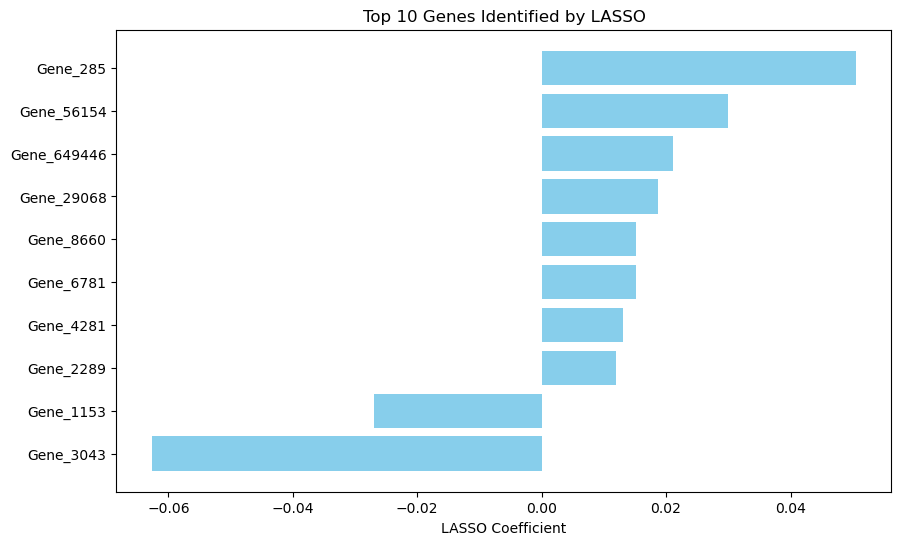

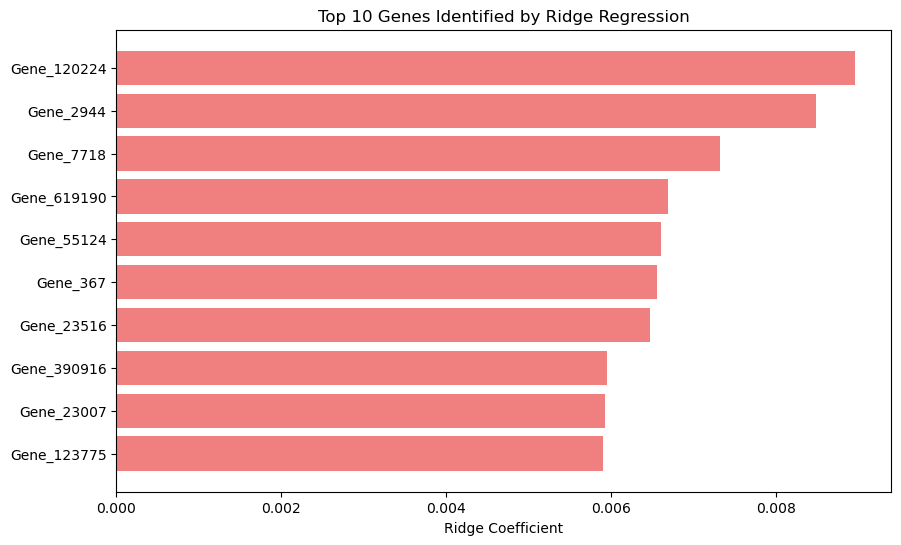

In [12]:
import matplotlib.pyplot as plt

# Plot LASSO coefficients
plt.figure(figsize=(10, 6))
plt.barh(lasso_results['Gene'][:10], lasso_results['LASSO Coefficient'][:10], color='skyblue')
plt.xlabel('LASSO Coefficient')
plt.title('Top 10 Genes Identified by LASSO')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
plt.show()

# Plot Ridge coefficients
plt.figure(figsize=(10, 6))
plt.barh(ridge_results['Gene'][:10], ridge_results['Ridge Coefficient'][:10], color='lightcoral')
plt.xlabel('Ridge Coefficient')
plt.title('Top 10 Genes Identified by Ridge Regression')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
plt.show()


In [13]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined)

# Create a pipeline that fills missing values and scales data
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # or 'median'
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict probabilities and classes
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = pipeline.predict(X_test)


In [6]:
y_combined.shape

(199,)

In [7]:
y_pred.shape

(40,)

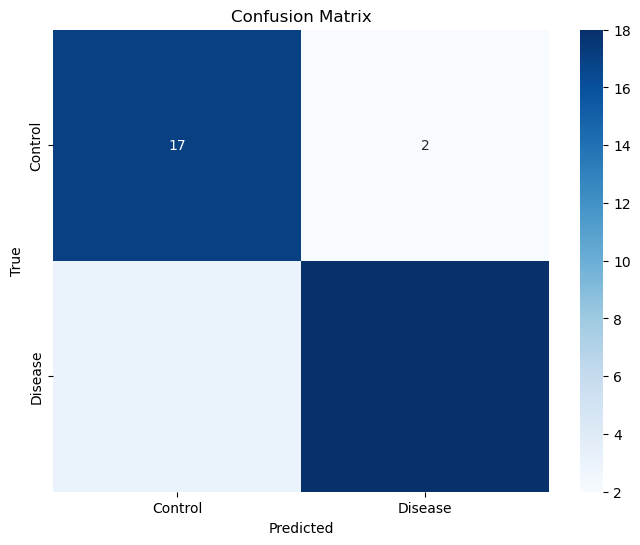

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assume `y_pred` is the predicted labels from your classifier
# y_pred = classifier.predict(X_scaled)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'Disease'], yticklabels=['Control', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [9]:
print(cm)

[[17  2]
 [ 3 18]]


In [14]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined)

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Create a dictionary to store the results
results = {}

# Loop through classifiers, fit the model, and evaluate
for name, classifier in classifiers.items():
    # Create a pipeline that fills missing values, scales data, and applies classifier
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # or 'median'
        ('scaler', StandardScaler()),
        ('classifier', classifier)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities and classes
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = pipeline.predict(X_test)
    
    # Evaluate model
    auc_score = roc_auc_score(y_test, y_pred_proba)
    class_report = classification_report(y_test, y_pred)
    
    # Store results
    results[name] = {
        'AUC': auc_score,
        'Classification Report': class_report
    }

# Print results for each classifier
for name, result in results.items():
    print(f"Results for {name}:")
    print(f"AUC: {result['AUC']}")
    print(f"Classification Report:\n{result['Classification Report']}")
    print('-' * 80)

# Optionally, plot ROC curves for each classifier
plt.figure(figsize=(10, 8))
for name, classifier in classifiers.items():
    # Get the ROC curve data
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('classifier', classifier)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')

# Plot diagonal line for random classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Classifiers')
plt.legend(loc='lower right')


# Adjust the layout to avoid overlap
plt.tight_layout()

# Save the figure to a specified folder
plt.savefig('results/ROC.png')  # Change 'path_to_folder' to your desired directory

plt.show()


Results for Logistic Regression:
AUC: 0.9774436090225564
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        19
           1       0.90      0.86      0.88        21

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.88        40

--------------------------------------------------------------------------------
Results for SVM:
AUC: 0.8646616541353384
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77        19
           1       0.80      0.76      0.78        21

    accuracy                           0.78        40
   macro avg       0.78      0.78      0.77        40
weighted avg       0.78      0.78      0.78        40

--------------------------------------------------------------------------------
Results for Random Forest:
AUC: 0.916040

NameError: name 'roc_curve' is not defined

<Figure size 1000x800 with 0 Axes>

[[17  2]
 [ 3 18]]


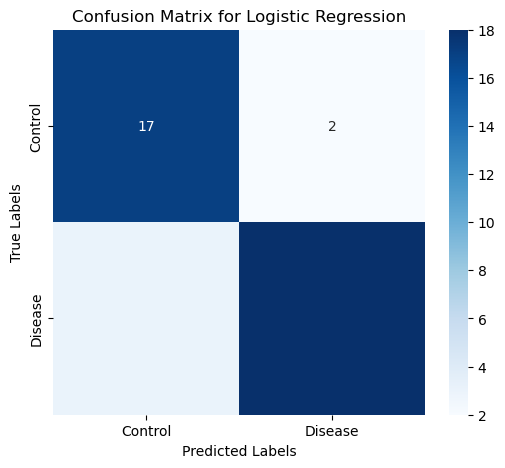

[[15  4]
 [ 5 16]]


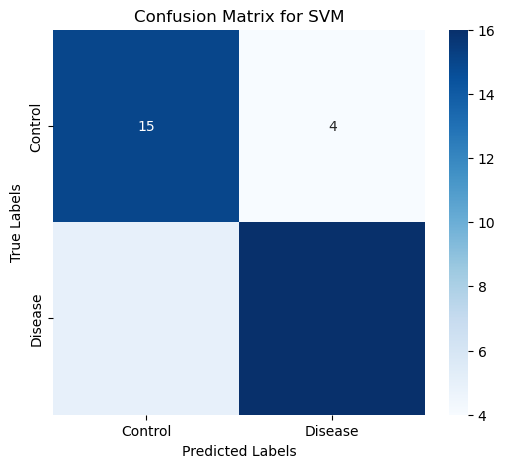

[[16  3]
 [ 5 16]]


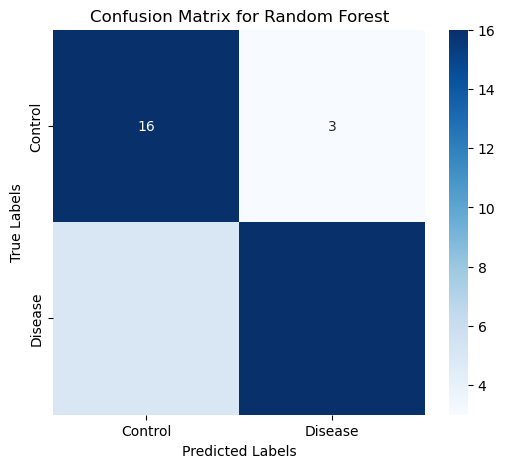

[[12  7]
 [ 4 17]]


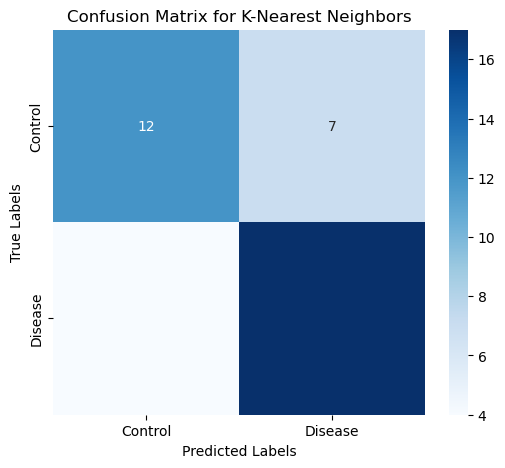

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Loop through classifiers to plot confusion matrix
for name, classifier in classifiers.items():
    # Create a pipeline with imputer, scaler, and classifier
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('classifier', classifier)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Predict labels
    y_pred = pipeline.predict(X_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'Disease'], yticklabels=['Control', 'Disease'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()



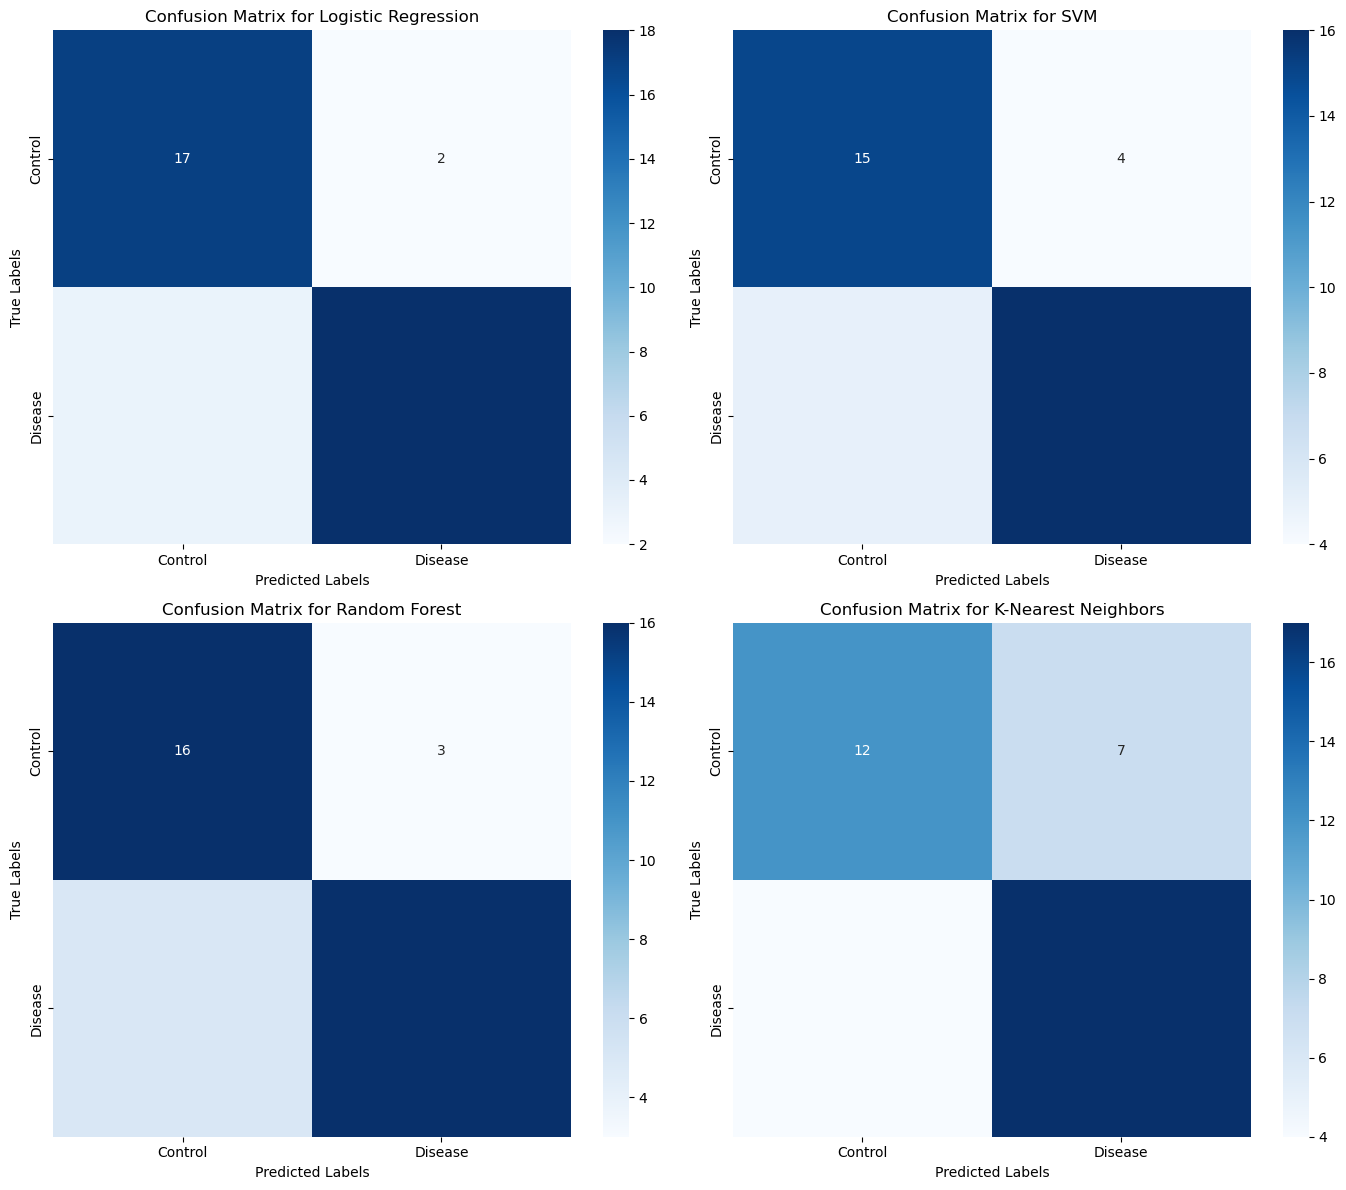

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Define the classifiers dictionary (make sure to define your classifiers)
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Create a figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Loop through classifiers to plot confusion matrix
for i, (name, classifier) in enumerate(classifiers.items()):
    # Create a pipeline with imputer, scaler, and classifier
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('classifier', classifier)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Predict labels
    y_pred = pipeline.predict(X_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix using seaborn heatmap
    row = i // 2  # Determine the row index for the subplot
    col = i % 2   # Determine the column index for the subplot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'Disease'], yticklabels=['Control', 'Disease'], ax=axes[row, col])
    
    # Set plot title, labels, and ticks
    axes[row, col].set_title(f'Confusion Matrix for {name}')
    axes[row, col].set_xlabel('Predicted Labels')
    axes[row, col].set_ylabel('True Labels')

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()


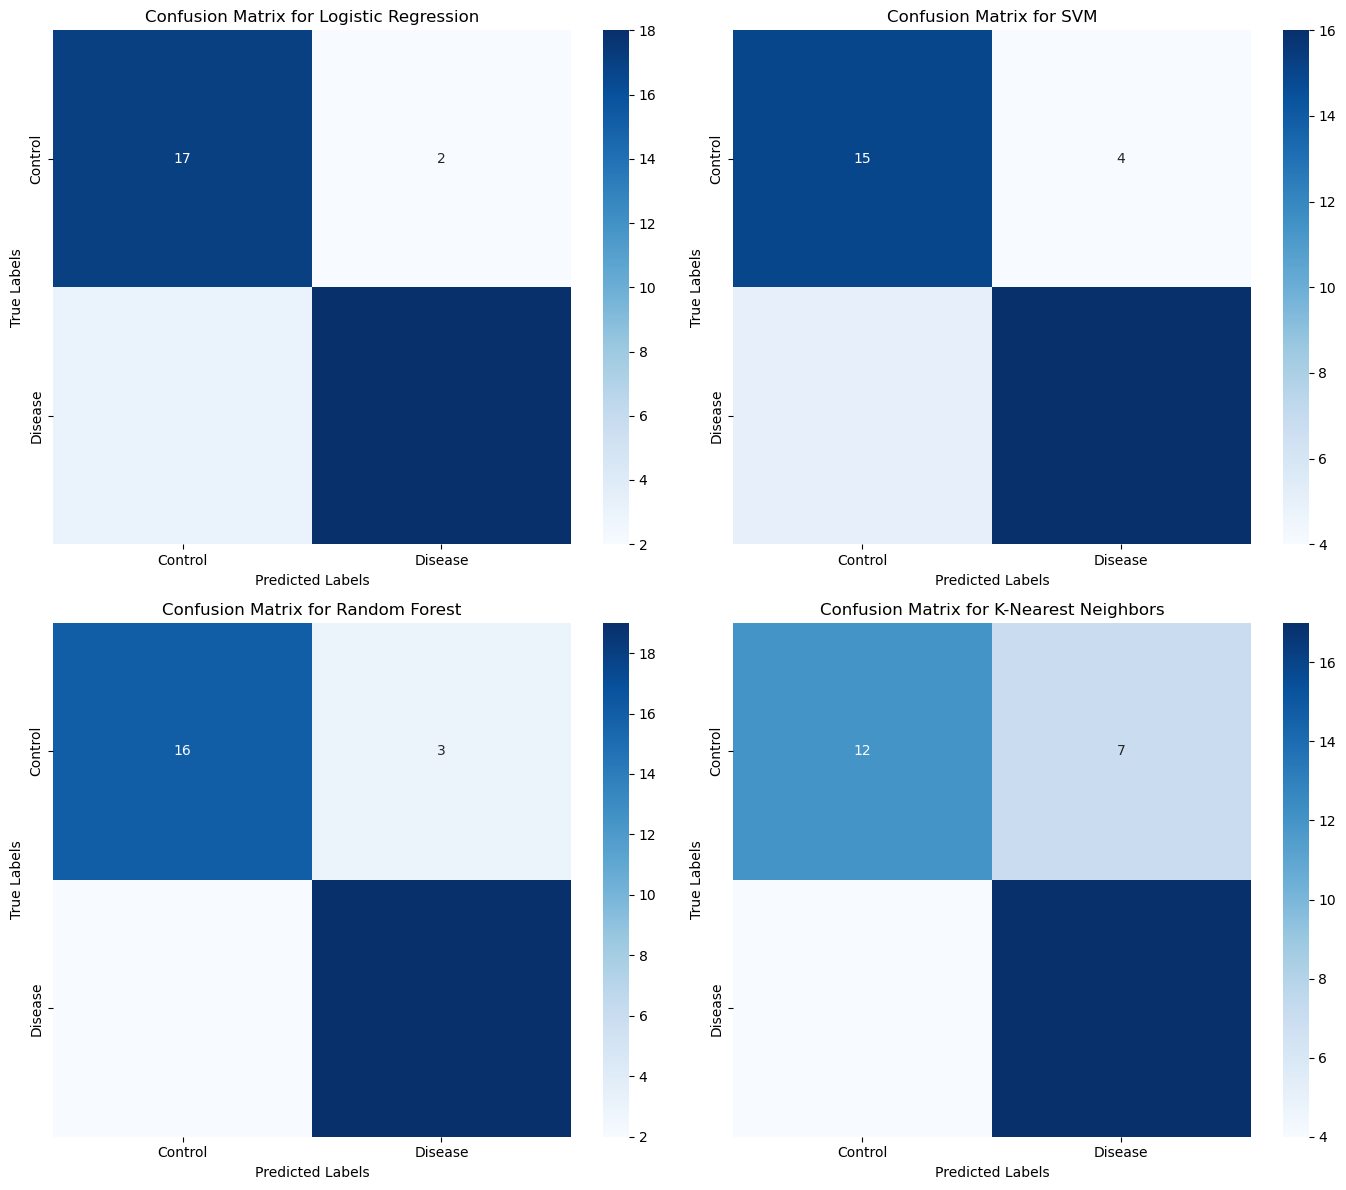

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Define the classifiers dictionary (make sure to define your classifiers)
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Create a figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Loop through classifiers to plot confusion matrix
for i, (name, classifier) in enumerate(classifiers.items()):
    # Create a pipeline with imputer, scaler, and classifier
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('classifier', classifier)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Predict labels
    y_pred = pipeline.predict(X_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix using seaborn heatmap
    row = i // 2  # Determine the row index for the subplot
    col = i % 2   # Determine the column index for the subplot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'Disease'], yticklabels=['Control', 'Disease'], ax=axes[row, col])
    
    # Set plot title, labels, and ticks
    axes[row, col].set_title(f'Confusion Matrix for {name}')
    axes[row, col].set_xlabel('Predicted Labels')
    axes[row, col].set_ylabel('True Labels')

# Adjust the layout to avoid overlap
plt.tight_layout()

# Save the figure to a specified folder
plt.savefig('./results/confusion_matrices.png')  # Change 'path_to_folder' to your desired directory

# Show the plot (optional)
plt.show()


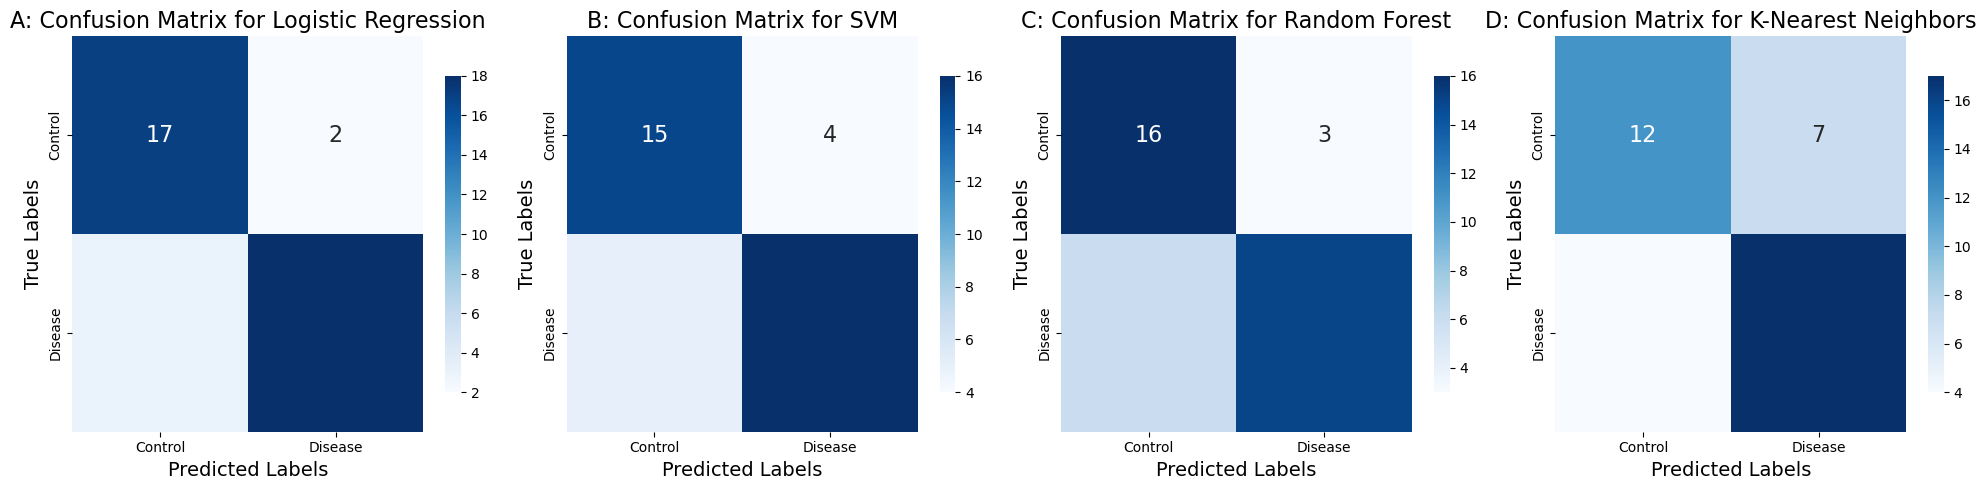

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Define the classifiers dictionary (make sure to define your classifiers)
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Create a figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Adjust figsize as needed

# Loop through classifiers to plot confusion matrix
for i, (name, classifier) in enumerate(classifiers.items()):
    # Create a pipeline with imputer, scaler, and classifier
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('classifier', classifier)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Predict labels
    y_pred = pipeline.predict(X_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix using seaborn heatmap with increased font size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'Disease'], 
                yticklabels=['Control', 'Disease'], ax=axes[i], annot_kws={"size": 16}, cbar_kws={'shrink': 0.8})
    
    # Set plot title, labels, and ticks with increased font size
    axes[i].set_title(f'{chr(65+i)}: Confusion Matrix for {name}', fontsize=16)
    axes[i].set_xlabel('Predicted Labels', fontsize=14)
    axes[i].set_ylabel('True Labels', fontsize=14)

# Adjust the layout to avoid overlap
plt.tight_layout()

# Save the figure to a specified folder
plt.savefig('results/confusion_matrices.png')  # Change 'path_to_folder' to your desired directory

# Show the plot (optional)
plt.show()


In [22]:
# Example for Random Forest or XGBoost
for name, classifier in classifiers.items():
    if hasattr(classifier, 'feature_importances_'):  # Check if the model has feature importance attribute
        importance = classifier.feature_importances_
        feature_importance = sorted(zip(df_combined.columns, importance), key=lambda x: x[1], reverse=True)

        print(f"Top features for {name}:")
        for feature, score in feature_importance[:20]:  # Top 10 important features
            print(f"{feature}: {score:.4f}")


Top features for Random Forest:
Gene_84964: 0.0070
Gene_55661: 0.0061
Gene_5935: 0.0061
Gene_92675: 0.0056
Gene_160: 0.0055
Gene_55199: 0.0050
Gene_146691: 0.0045
Gene_3006: 0.0043
Gene_152926: 0.0042
Gene_604: 0.0042
Gene_6526: 0.0040
Gene_7323: 0.0039
Gene_113451: 0.0038
Gene_5257: 0.0038
Gene_84991: 0.0036
Gene_23221: 0.0036
Gene_440482: 0.0035
Gene_54502: 0.0033
Gene_2941: 0.0032
Gene_5395: 0.0032


In [20]:
# Example for Logistic Regression or SVM
for name, classifier in classifiers.items():
    if hasattr(classifier, 'coef_'):  # Linear models have 'coef_' attribute for feature importance
        coef = classifier.coef_.flatten()
        feature_importance = sorted(zip(df_combined.columns, coef), key=lambda x: abs(x[1]), reverse=True)

        print(f"Top features for {name}:")
        for feature, score in feature_importance[:20]:  # Top 10 most important features
            print(f"{feature}: {score:.4f}")


Top features for Logistic Regression:
Gene_23516: 0.0836
Gene_3043: -0.0761
Gene_133: 0.0756
Gene_353322: 0.0735
Gene_1663: -0.0730
Gene_3039: -0.0715
Gene_3040: -0.0714
Gene_727856: -0.0707
Gene_54810: -0.0700
Gene_7422: 0.0696
Gene_120224: 0.0677
Gene_10112: -0.0676
Gene_29923: 0.0662
Gene_100133005: -0.0636
Gene_2277: -0.0631
Gene_157489: 0.0617
Gene_1415: -0.0611
Gene_57393: -0.0607
Gene_4233: -0.0598
Gene_7718: 0.0595


Top features for Random Forest: Gene_84964: 0.0070, Gene_55661: 0.0061, Gene_5935: 0.0061, Gene_92675: 0.0056, Gene_160: 0.0055, Gene_55199: 0.0050, Gene_146691: 0.0045, Gene_3006: 0.0043, Gene_152926: 0.0042, Gene_604: 0.0042


c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


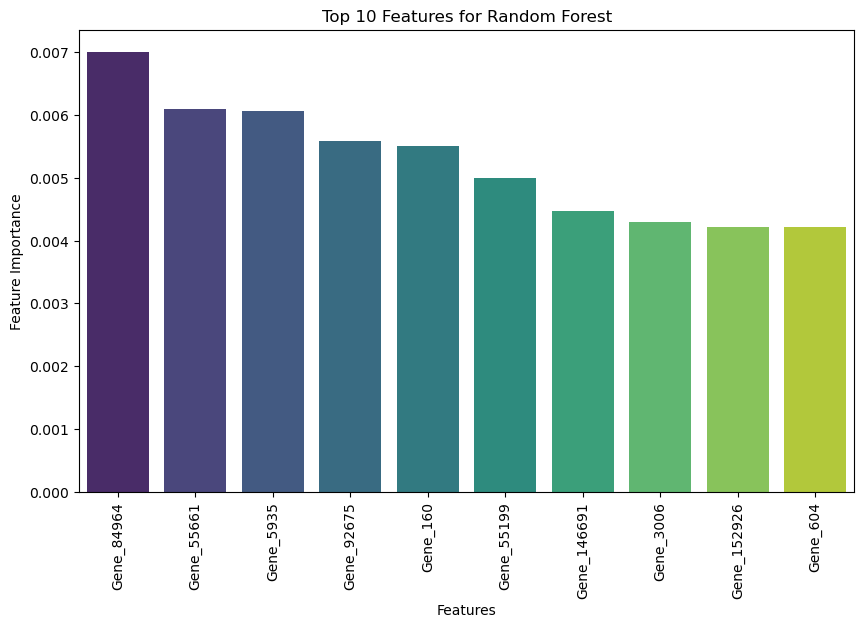

In [23]:
# Plot feature importances for RandomForest, XGBoost, etc.
for name, classifier in classifiers.items():
    if hasattr(classifier, 'feature_importances_'):
        importance = classifier.feature_importances_
        feature_importance = sorted(zip(df_combined.columns, importance), key=lambda x: x[1], reverse=True)

        top_features = [f"{feature}: {score:.4f}" for feature, score in feature_importance[:10]]
        print(f"Top features for {name}: {', '.join(top_features)}")

        # Plotting
        plt.figure(figsize=(10, 6))
        sns.barplot(x=[x[0] for x in feature_importance[:10]], y=[x[1] for x in feature_importance[:10]], palette='viridis')
        plt.title(f"Top 10 Features for {name}")
        plt.ylabel('Feature Importance')
        plt.xlabel('Features')
        plt.xticks(rotation=90)
        plt.show()


                          Gene  log2FoldChange    pvalue
GeneId                                                  
Gene_100287102  Gene_100287102       -0.085732  0.342348
Gene_653635        Gene_653635        0.005862  0.781001
Gene_102466751  Gene_102466751       -0.006062  0.947341
Gene_100996442  Gene_100996442       -0.081112  0.570004
Gene_729737        Gene_729737       -0.036185  0.522175
...                        ...             ...       ...
Gene_4541            Gene_4541        0.015259  0.754701
Gene_4556            Gene_4556        0.046650  0.535289
Gene_4519            Gene_4519        0.033888  0.448908
Gene_4571            Gene_4571        0.100120  0.590401
disease                disease       33.219281       NaN

[18346 rows x 3 columns]


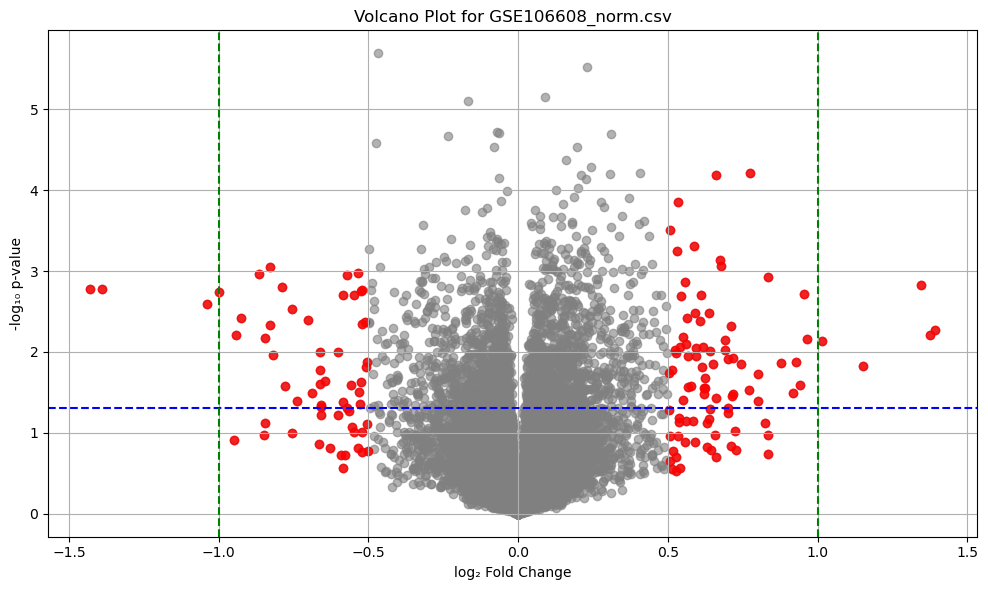

                          Gene  log2FoldChange    pvalue
GeneId                                                  
Gene_100287102  Gene_100287102        0.063464  0.442529
Gene_653635        Gene_653635       -0.019790  0.523904
Gene_102466751  Gene_102466751        0.040267  0.685247
Gene_100996442  Gene_100996442        0.036785  0.084531
Gene_729737        Gene_729737       -0.042515  0.363608
...                        ...             ...       ...
Gene_4556            Gene_4556        0.092150  0.020131
Gene_4519            Gene_4519        0.046115  0.011139
Gene_4576            Gene_4576        0.107840  0.023137
Gene_4571            Gene_4571        0.102108  0.044228
disease                disease       33.219281       NaN

[23095 rows x 3 columns]


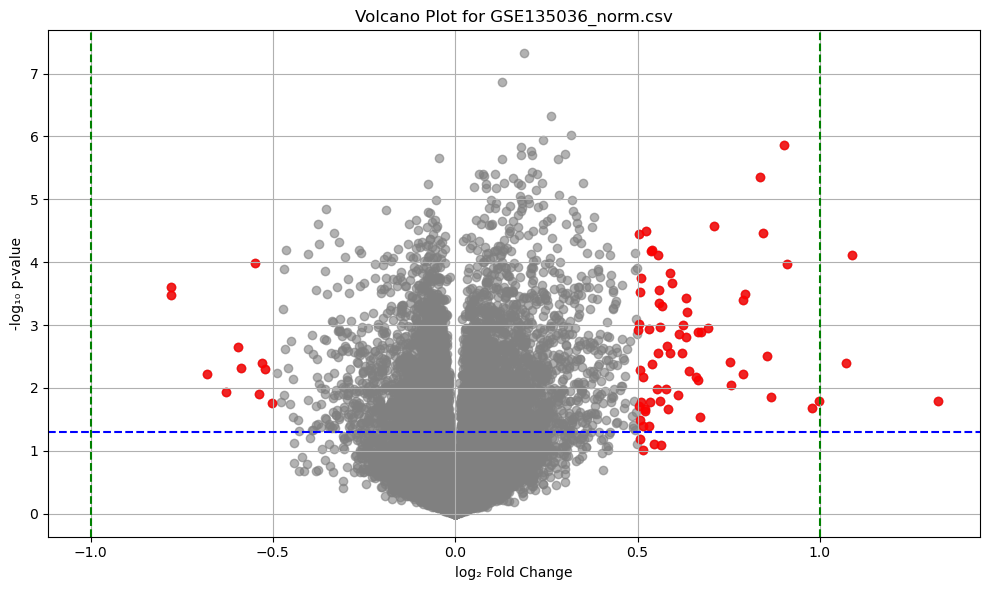

                          Gene  log2FoldChange    pvalue
GeneId                                                  
Gene_100287102  Gene_100287102       -0.126185  0.439119
Gene_653635        Gene_653635       -0.017213  0.404177
Gene_102466751  Gene_102466751       -0.036418  0.510804
Gene_100996442  Gene_100996442       -0.028978  0.354989
Gene_729737        Gene_729737       -0.060346  0.085197
...                        ...             ...       ...
Gene_4556            Gene_4556        0.092594  0.014428
Gene_4519            Gene_4519        0.051863  0.043767
Gene_4576            Gene_4576        0.094007  0.012162
Gene_4571            Gene_4571        0.043958  0.180756
disease                disease       33.219281       NaN

[21360 rows x 3 columns]


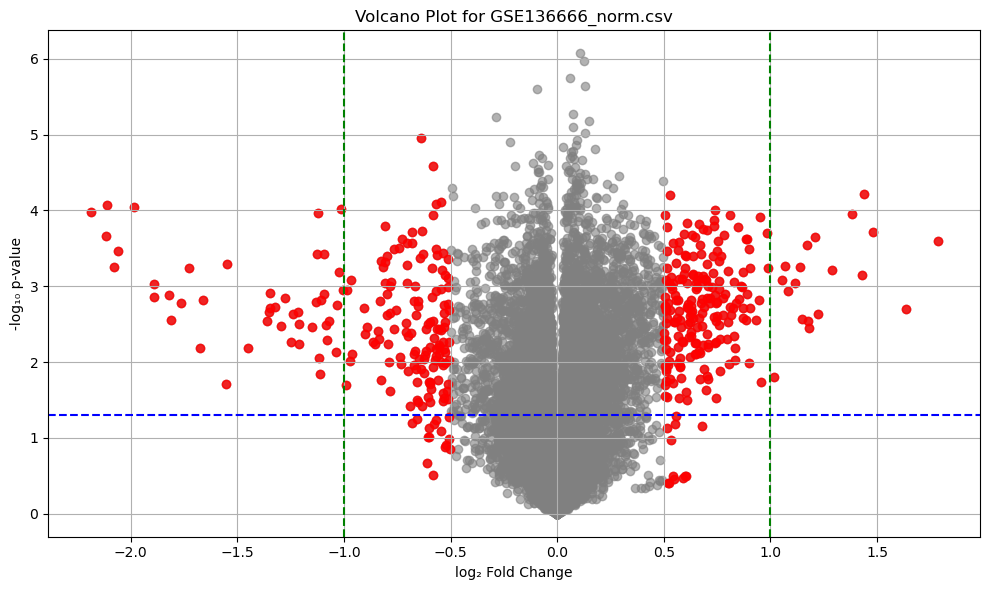

                          Gene  log2FoldChange    pvalue
GeneId                                                  
Gene_653635        Gene_653635       -0.123201  0.048773
Gene_100996442  Gene_100996442       -0.000715  0.995071
Gene_729737        Gene_729737        0.138599  0.439576
Gene_102723897  Gene_102723897       -0.067872  0.220772
Gene_112268260  Gene_112268260        0.223135  0.070917
...                        ...             ...       ...
Gene_4556            Gene_4556        0.204616  0.281925
Gene_4519            Gene_4519       -0.006781  0.887960
Gene_4576            Gene_4576        0.093961  0.467505
Gene_4571            Gene_4571        0.012640  0.944354
disease                disease       33.219281       NaN

[16332 rows x 3 columns]


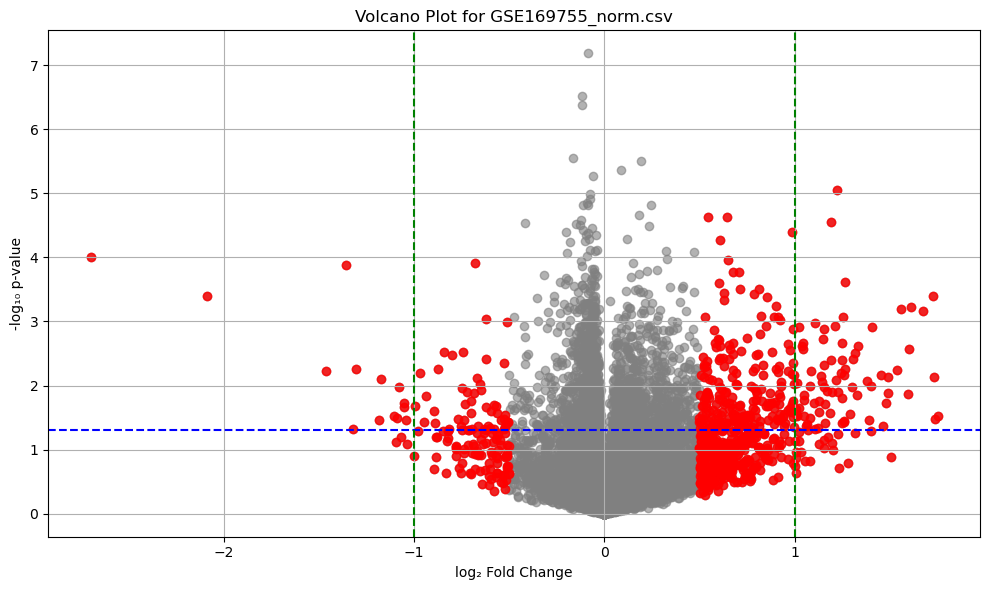

                          Gene  log2FoldChange    pvalue
GeneId                                                  
Gene_653635        Gene_653635        0.008412  0.421913
Gene_102466751  Gene_102466751        0.122581  0.131471
Gene_100996442  Gene_100996442       -0.056993  0.194795
Gene_729737        Gene_729737        0.002549  0.948848
Gene_102723897  Gene_102723897        0.021670  0.108947
...                        ...             ...       ...
Gene_4556            Gene_4556        0.102601  0.000476
Gene_4519            Gene_4519        0.041279  0.026984
Gene_4576            Gene_4576        0.094391  0.012260
Gene_4571            Gene_4571        0.073525  0.011056
disease                disease       33.219281       NaN

[20031 rows x 3 columns]


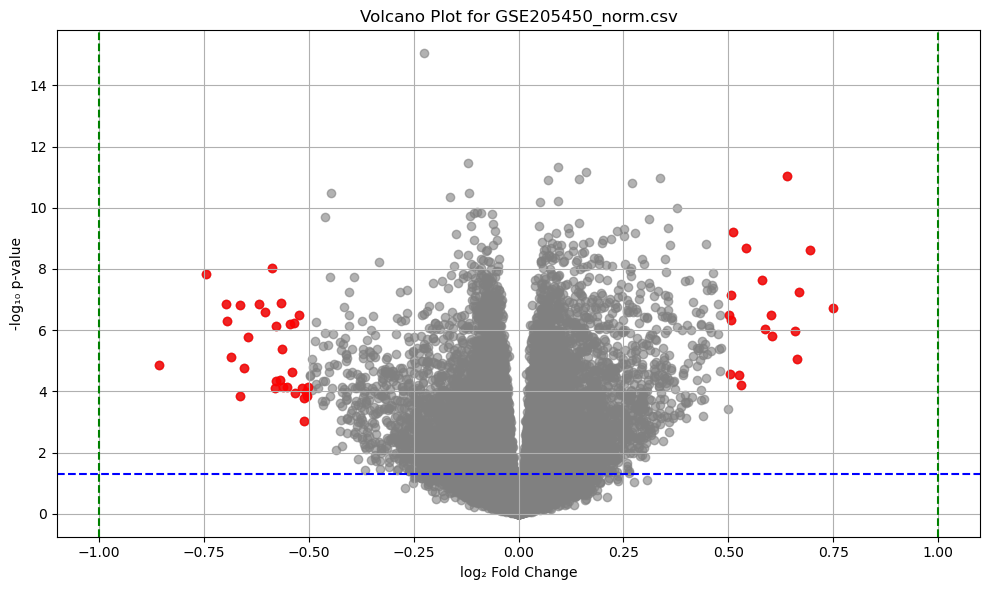

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# List of dataset filenames
datasets = [
    'GSE106608_norm.csv', 
    'GSE135036_norm.csv',
    'GSE136666_norm.csv',
    'GSE169755_norm.csv',
    'GSE205450_norm.csv'
]

# Define a function to process each dataset
def process_volcano_plot(file_name):
    # Load the dataset
    expression_data = pd.read_csv('./data/' +file_name, index_col=0)

    control_samples = [col for col in expression_data.columns if expression_data[col].iloc[-1] == 0]
    disease_samples = [col for col in expression_data.columns if expression_data[col].iloc[-1] == 1]    

    # Extract control and disease data
    control_data = expression_data[control_samples]
    disease_data = expression_data[disease_samples]

    # Handle missing data by dropping rows with any NaN values
    control_data = control_data.dropna()
    disease_data = disease_data.dropna()

    # Calculate Log2 Fold Change (log2FC) - only where there's no division by zero
    control_mean = control_data.mean(axis=1)
    disease_mean = disease_data.mean(axis=1)
    log2fc = np.log2((disease_mean + 1e-10) / (control_mean + 1e-10))  # Log2 fold change (disease/control)

    # Perform t-test for each gene to calculate p-values
    p_values = []
    for gene in expression_data.index:
        # Skip genes that have zero variance in both groups
        if np.var(control_data.loc[gene]) == 0 or np.var(disease_data.loc[gene]) == 0:
            p_values.append(np.nan)
        else:
            t_stat, p_value = stats.ttest_ind(control_data.loc[gene], disease_data.loc[gene])
            p_values.append(p_value)

    # Create a dataframe with log2FC and p-values
    volcano_df = pd.DataFrame({
        'Gene': expression_data.index,
        'log2FoldChange': log2fc,
        'pvalue': p_values
    })
    print(volcano_df)
    # Drop rows with NaN values in p-value or log2FoldChange columns
    volcano_df = volcano_df.dropna(subset=['log2FoldChange', 'pvalue'])

    # Calculate -log10(pvalue)
    volcano_df['-log10(pvalue)'] = -np.log10(volcano_df['pvalue'])

    # Plot the volcano plot
    plt.figure(figsize=(10, 6))
    plt.scatter(volcano_df['log2FoldChange'], volcano_df['-log10(pvalue)'], color='grey', alpha=0.6)

    # Highlight significant genes (log2FC > 1 or < -1 and p-value < 0.05)
    significant = (volcano_df['pvalue'] < 3) & (abs(volcano_df['log2FoldChange']) > 0.5)
    plt.scatter(volcano_df[significant]['log2FoldChange'], volcano_df[significant]['-log10(pvalue)'], color='red', alpha=0.8)

    # Adding threshold lines
    plt.axhline(-np.log10(0.05), color='blue', linestyle='--')  # p-value threshold line
    plt.axvline(-1, color='green', linestyle='--')  # log2FC threshold
    plt.axvline(1, color='green', linestyle='--')

    # Labels and title
    plt.xlabel('log₂ Fold Change')
    plt.ylabel('-log₁₀ p-value')
    plt.title(f'Volcano Plot for {file_name}')
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'{file_name}_volcano_plot.png')
    plt.show()

# Process each dataset and generate volcano plots
for dataset in datasets:
    process_volcano_plot(dataset)


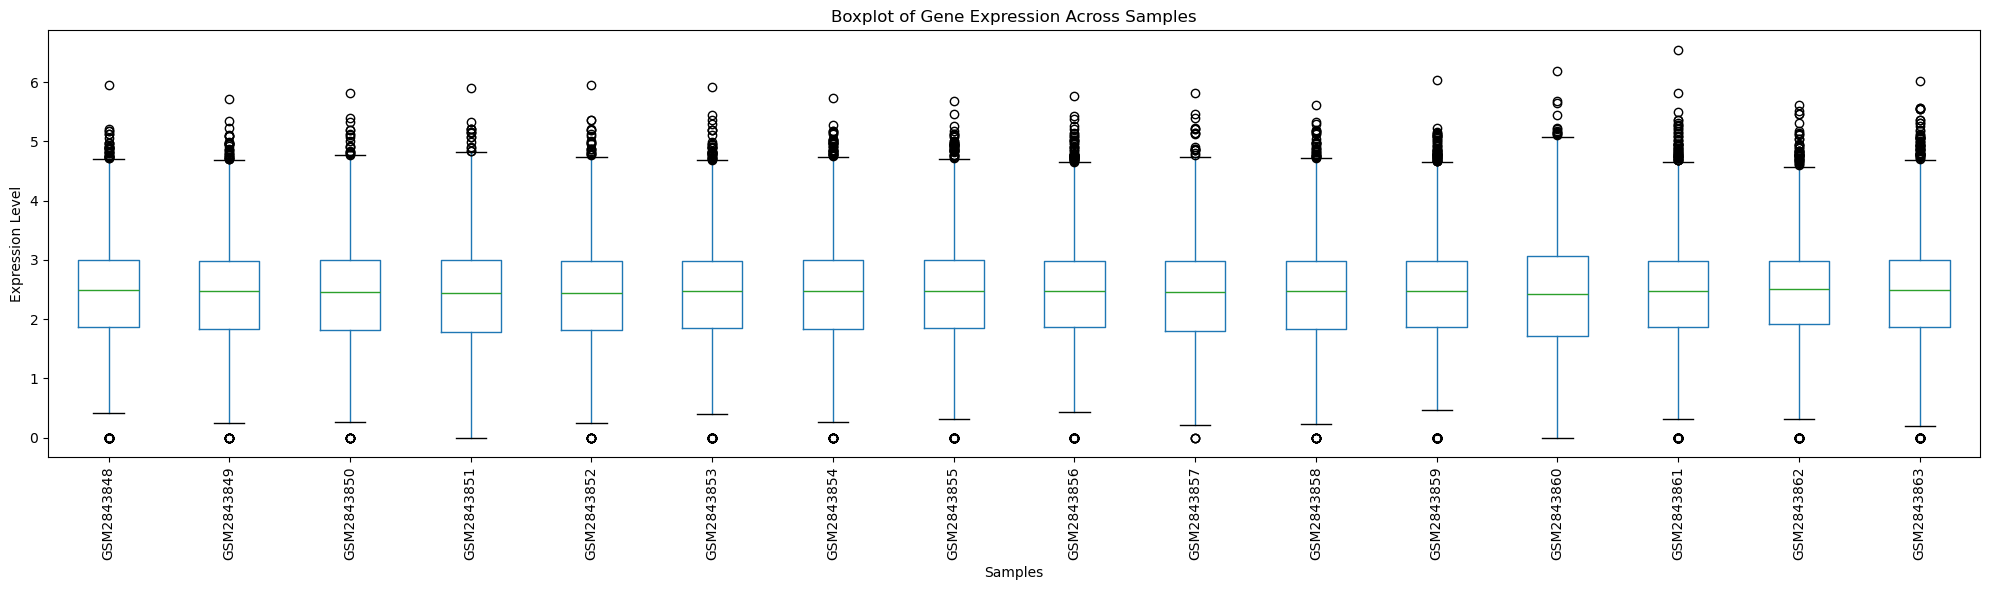

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load your gene expression CSV ===
file_path = './data/GSE106608_norm.csv'  # Change to your file
df = pd.read_csv(file_path)

# === Set GeneId as index (optional, for clarity) ===
df.set_index(df.columns[0], inplace=True)  # First column is GeneId

# === Plot boxplot ===
plt.figure(figsize=(20, 6))
df.boxplot(rot=90, grid=False)
plt.title("Boxplot of Gene Expression Across Samples")
plt.xlabel("Samples")
plt.ylabel("Expression Level")
plt.tight_layout()
plt.show()


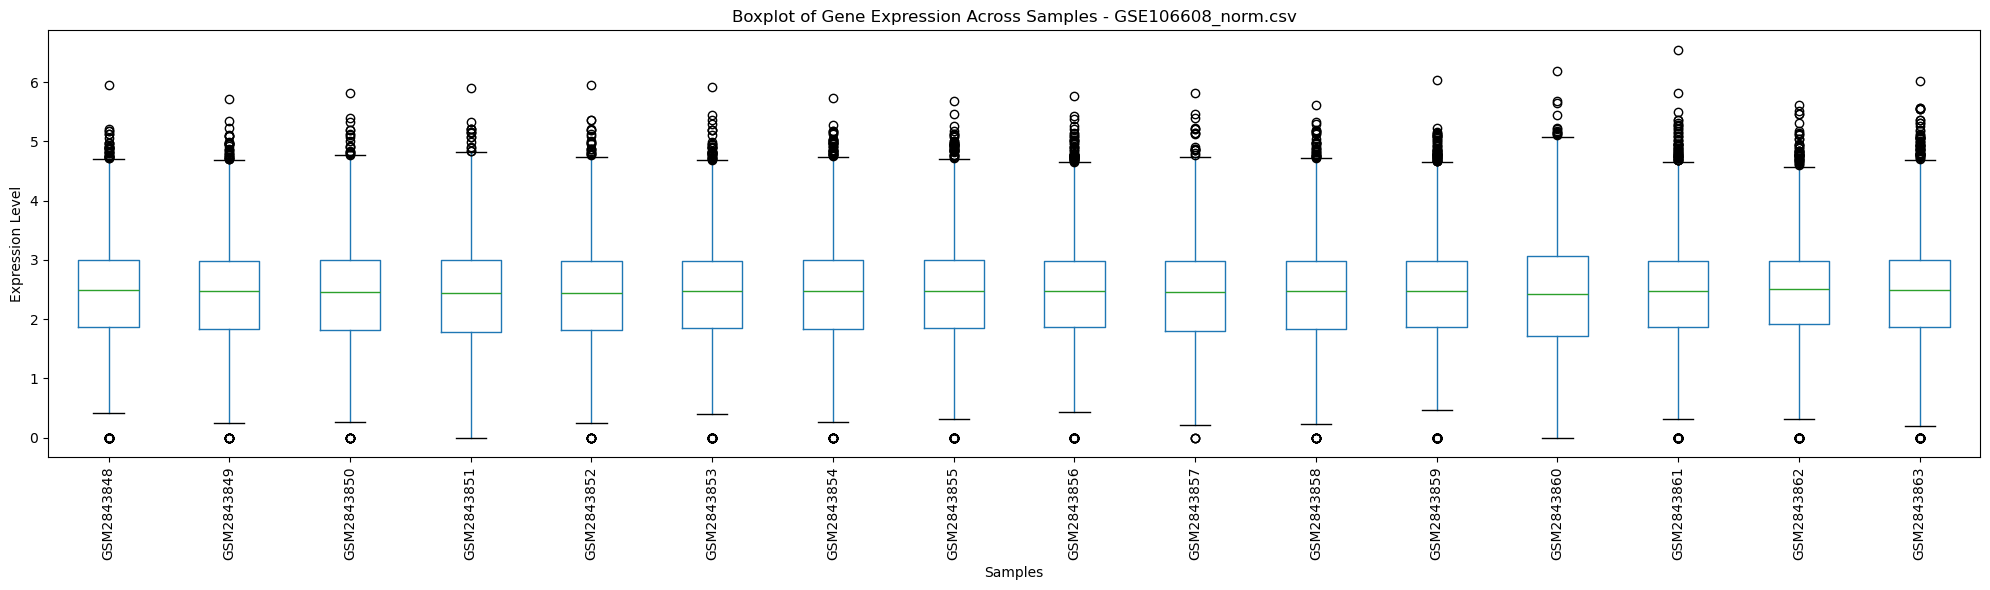

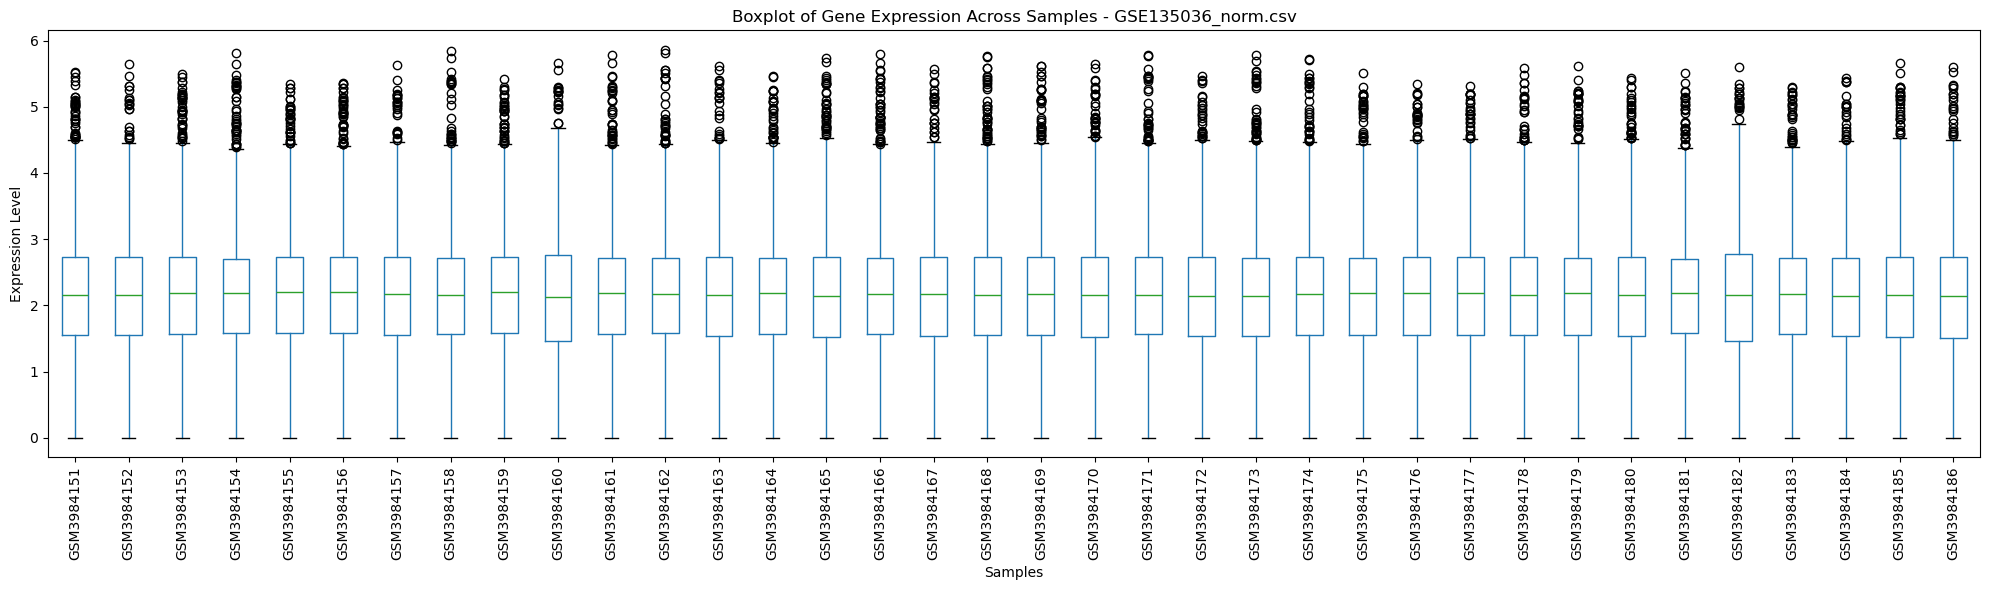

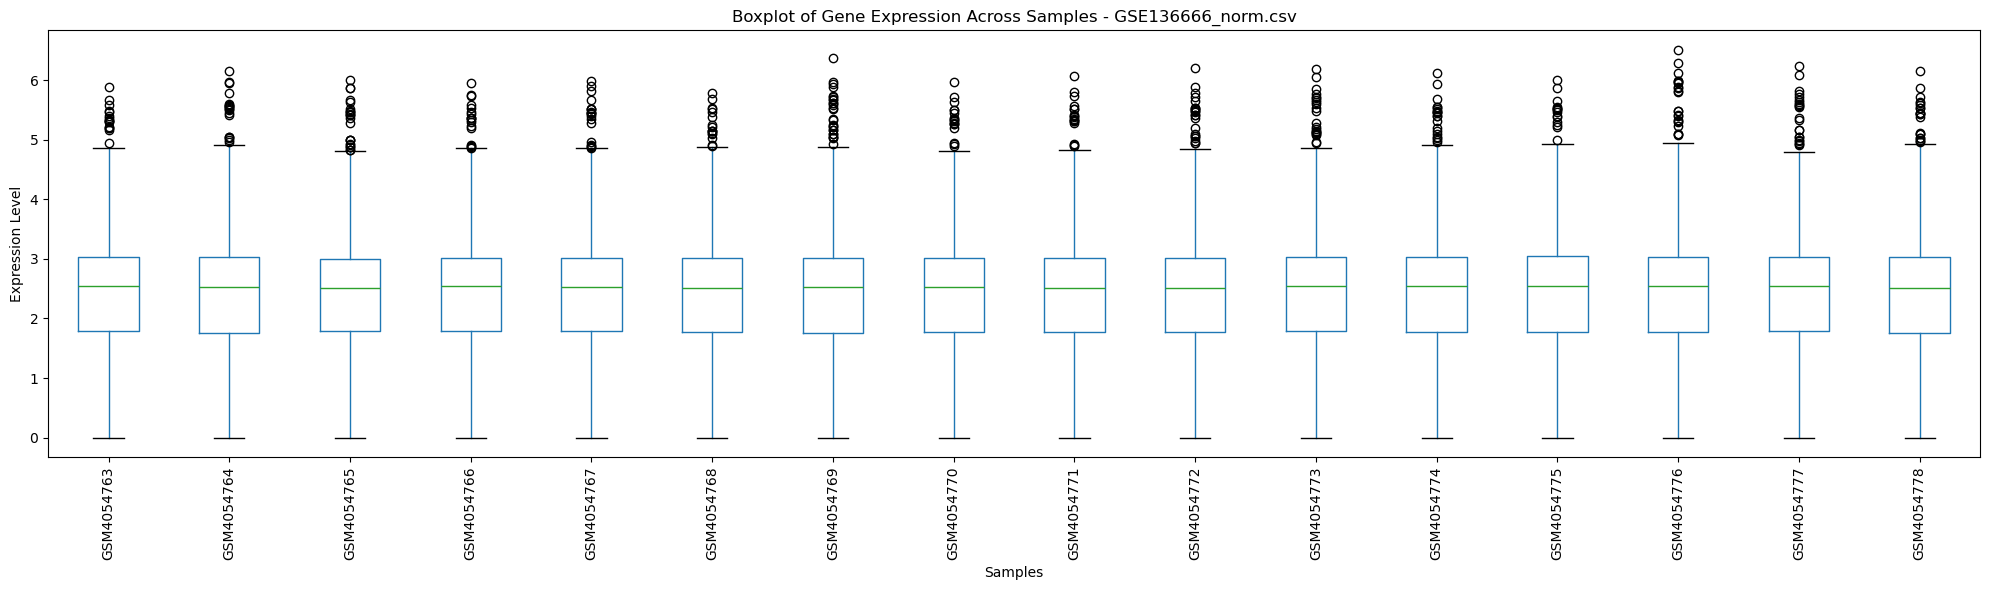

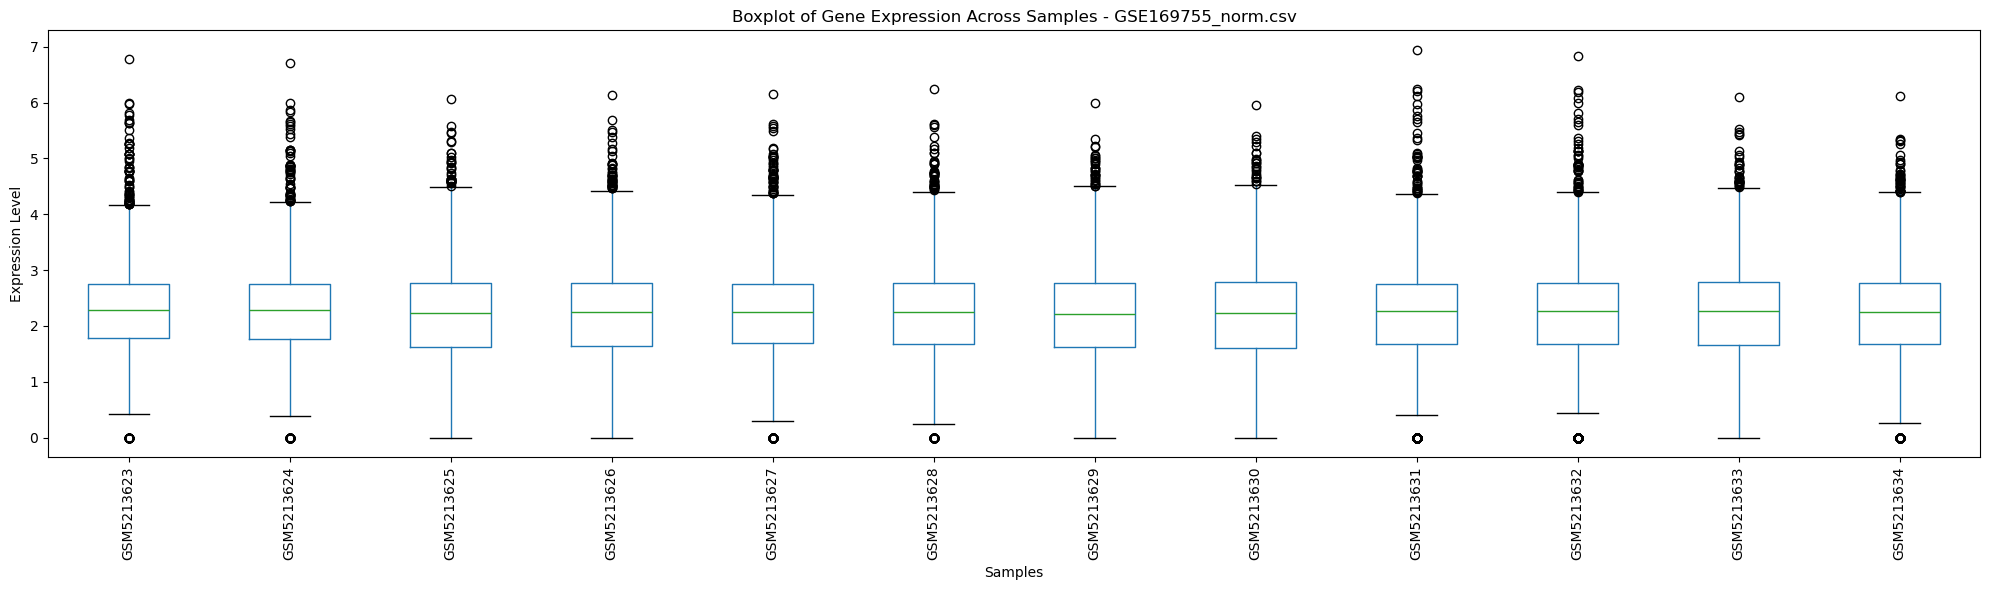

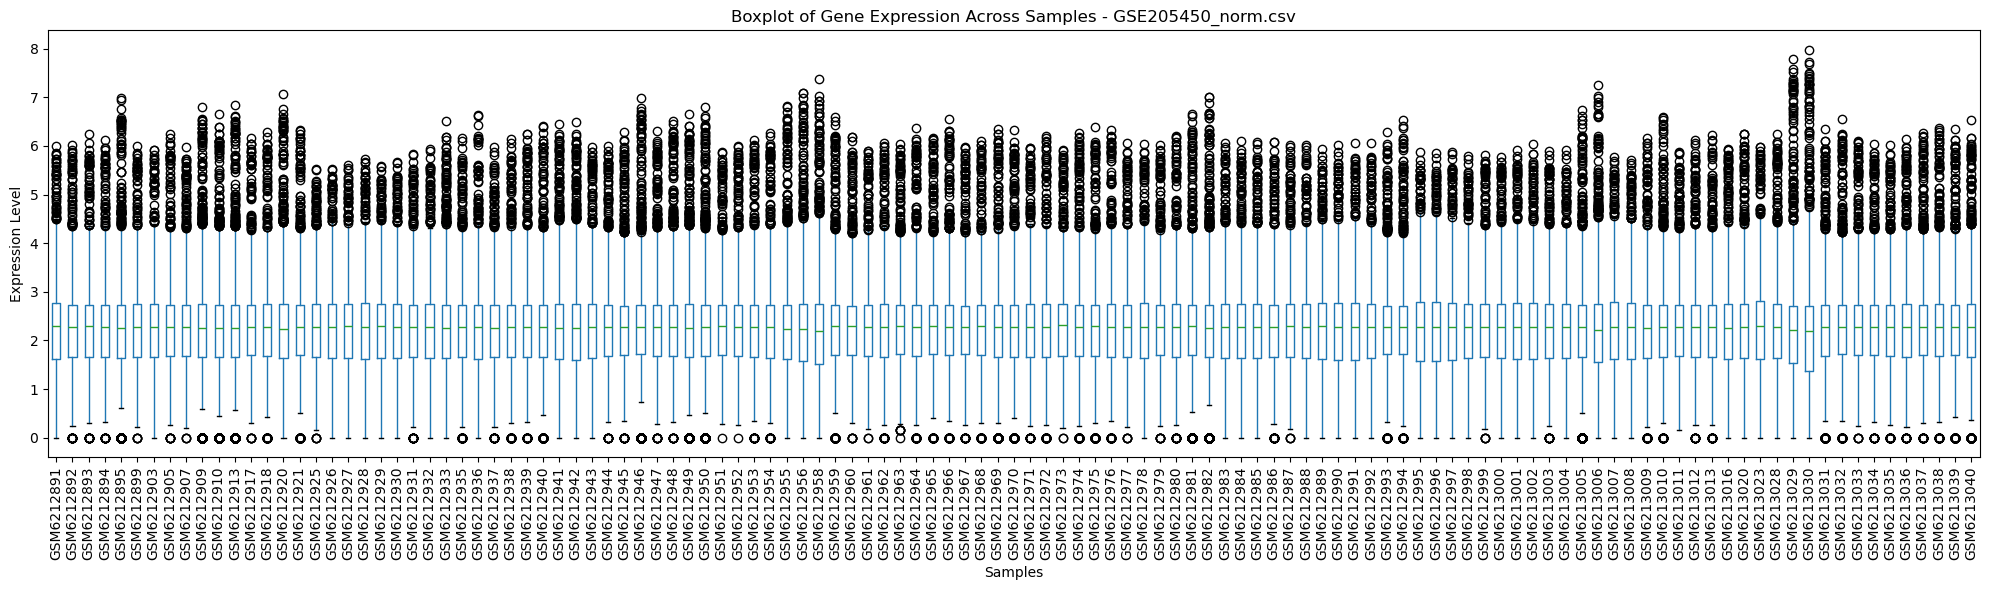

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# List of your file paths
file_paths = [
    './data/GSE106608_norm.csv',  # Replace with actual file paths for each dataset
    './data/GSE135036_norm.csv',
    './data/GSE136666_norm.csv',
    './data/GSE169755_norm.csv',
    './data/GSE205450_norm.csv'
]

# === Loop through each dataset and create a boxplot for each ===
for file_path in file_paths:
    # Load the dataset (each file is a CSV)
    df = pd.read_csv(file_path)
    
    # Set the GeneId as the index (since the first column contains GeneId)
    df.set_index(df.columns[0], inplace=True)  # First column is GeneId
    
    # === Create a box plot for each sample ===
    plt.figure(figsize=(20, 6))
    df.boxplot(rot=90, grid=False)
    plt.title(f"Boxplot of Gene Expression Across Samples - {file_path.split('/')[-1]}")
    plt.xlabel("Samples")
    plt.ylabel("Expression Level")
    plt.tight_layout()
    plt.show()
